In [143]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, classification_report, f1_score
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from joblib import dump, load
import os

optuna.logging.set_verbosity(optuna.logging.ERROR)
%matplotlib inline
# set the font globally
plt.rcParams.update({'font.family':'Arial'})
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2
# update the overall font size
plt.rcParams.update({'font.size':7})
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [76]:
# Load the binary 50/50 split dataset
df = pd.read_csv('data/diabetes_binary_5050split_health_indicators_BRFSS2015.csv')
df.drop_duplicates(inplace = True)
# Identify binary columns (assuming binary columns are of type int and have only two unique values: 0 and 1)
binary_columns = [col for col in df.columns if df[col].dropna().apply(lambda x: x in [0, 1]).all()]

# Non-binary columns
non_binary_columns = df.columns.difference(binary_columns)

# Initialize MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Normalize non-binary columns
df[non_binary_columns] = scaler.fit_transform(df[non_binary_columns])

# Display the first few rows of the normalized dataframe
df.head()


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,0.162791,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.50,0.166667,1.000000,0.0,1.0,0.250000,1.0,1.0
1,0.0,1.0,1.0,1.0,0.162791,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.50,0.000000,0.000000,0.0,1.0,0.916667,1.0,1.0
2,0.0,0.0,0.0,1.0,0.162791,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.00,0.000000,0.333333,0.0,1.0,1.000000,1.0,1.0
3,0.0,1.0,1.0,1.0,0.186047,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.50,0.000000,0.100000,0.0,1.0,0.833333,1.0,1.0
4,0.0,0.0,0.0,1.0,0.197674,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.25,0.000000,0.000000,0.0,0.0,0.583333,0.8,1.0


In [77]:
# Separate features and target
X = df.drop('Diabetes_binary', axis=1)
y = df['Diabetes_binary']

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, shuffle = True)

In [79]:
# Assuming X_train is your training dataset and is a pandas DataFrame
# Sample 5% of the data
sampled_data = X_train.sample(frac=0.10, random_state=42)

# Calculate means and standard deviations for the full dataset and the sample
full_means = X_train.mean()
full_stds = X_train.std()
sample_means = sampled_data.mean()
sample_stds = sampled_data.std()

# Create a dataframe for comparison
comparison_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Full Mean': full_means,
    'Sample Mean': sample_means,
    'Full Std Dev': full_stds,
    'Sample Std Dev': sample_stds
})

comparison_df.reset_index(drop=True, inplace=True)
print(comparison_df)

                 Feature  Full Mean  Sample Mean  Full Std Dev  Sample Std Dev
0                 HighBP   0.570450     0.567025      0.495017        0.495539
1               HighChol   0.530338     0.534547      0.499084        0.498857
2              CholCheck   0.975010     0.971452      0.156097        0.166549
3                    BMI   0.208759     0.208706      0.083123        0.082970
4                 Smoker   0.483398     0.468349      0.499729        0.499049
5                 Stroke   0.063530     0.062681      0.243917        0.242413
6   HeartDiseaseorAttack   0.149610     0.152669      0.356692        0.359705
7           PhysActivity   0.695525     0.693008      0.460189        0.461294
8                 Fruits   0.603302     0.594332      0.489217        0.491072
9                Veggies   0.784274     0.782168      0.411330        0.412815
10     HvyAlcoholConsump   0.044002     0.049028      0.205101        0.215948
11         AnyHealthcare   0.953950     0.950972    

# Modeling

## KNN Elbow Method

In [80]:
from joblib import Parallel, delayed


def train_and_evaluate_knn(n_neighbors, X_train, y_train, X_test, y_test):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train.values, y_train)
    train_predictions = knn.predict(X_train.values)
    test_predictions = knn.predict(X_test.values)
    train_accuracy = accuracy_score(y_train, train_predictions)
    test_accuracy = accuracy_score(y_test, test_predictions)
    return n_neighbors, train_accuracy, test_accuracy

In [81]:

train_accuracies = []
test_accuracies = []
# List of neighbors to try
neighbors_range = range(1, 50)

# Parallel execution
results = Parallel(n_jobs=-1)(delayed(train_and_evaluate_knn)(n, X_train, y_train, X_test, y_test) for n in neighbors_range)

# Unpacking results
for n_neighbors, train_accuracy, test_accuracy in results:
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

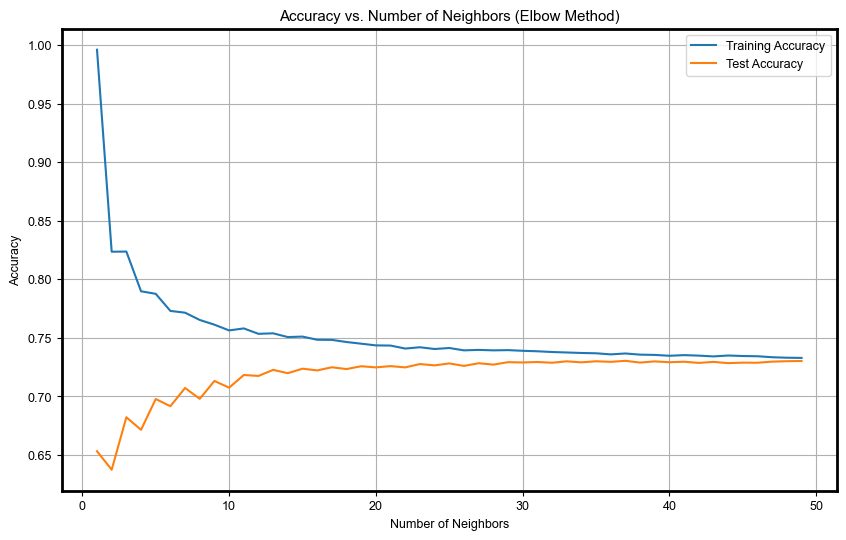

In [82]:
plt.figure(figsize=(10, 6))
plt.plot(neighbors_range, train_accuracies, label="Training Accuracy")
plt.plot(neighbors_range, test_accuracies, label="Test Accuracy")
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Number of Neighbors (Elbow Method)")
plt.legend()
plt.grid(True)
plt.savefig('figures/knn_full.svg', format='svg')
plt.savefig('figures/knn_full.png', dpi = 300)

plt.show()

## Hyperparameter Optimization

In [83]:
lr_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['saga', 'liblinear']
}

knn_params = {
    'n_neighbors': [7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'p': [1, 2] 
}

dt_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_params = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

xgb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9],
    'min_child_weight': [1, 2, 3],
    'gamma': [0, 0.1, 0.2],
    #'subsample': [0.7, 0.8, 0.9],
    #'colsample_bytree': [0.7, 0.8, 0.9],
    #'reg_lambda': [0.01, 0.1, 1],
    #'reg_alpha': [0, 0.1, 0.2]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [84]:
sample_indices = X_train.sample(frac=0.05, random_state=42).index

X_sample = X_train.loc[sample_indices]
y_sample = y_train.loc[sample_indices]

In [85]:
lr_grid = GridSearchCV(LogisticRegression(max_iter=10000), lr_params, cv=cv, n_jobs=-1, verbose = 1)
lr_best = lr_grid.fit(X_sample, y_sample)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [86]:
lr_grid.best_params_

{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}

In [87]:
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=cv, n_jobs=-1, verbose = 1)
knn_best = knn_grid.fit(X_sample.values, y_sample)  # As KNN needs .values

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [88]:
knn_grid.best_params_

{'n_neighbors': 15, 'p': 1, 'weights': 'uniform'}

In [89]:
dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=cv, n_jobs=-1, verbose = 1)
dt_best = dt_grid.fit(X_sample, y_sample)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [90]:
dt_grid.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 10}

In [91]:
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=cv, n_jobs=-1, verbose = 1)
rf_best = rf_grid.fit(X_sample, y_sample)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


In [92]:
rf_grid.best_params_

{'criterion': 'entropy',
 'max_depth': 20,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 100}

In [93]:
xgb_clf = XGBClassifier(eval_metric='logloss', device ="cpu", random_state=42)
xgb_grid = GridSearchCV(xgb_clf, xgb_params, cv=cv, n_jobs=-1, verbose = True)
xgb_best = xgb_grid.fit(X_sample, y_sample)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


In [94]:
xgb_grid.best_params_

{'gamma': 0,
 'learning_rate': 0.01,
 'max_depth': 3,
 'min_child_weight': 1,
 'n_estimators': 300}

## Model Evaluation

### Logistic Regression

In [95]:
lr = LogisticRegression(max_iter=10000, **lr_best.best_params_)
lr.fit(X_train, y_train)
lr_predictions = lr.predict(X_test)
print("Logistic Regression Classification Report:\n")
print(classification_report(y_test, lr_predictions))

Logistic Regression Classification Report:

              precision    recall  f1-score   support

         0.0       0.75      0.72      0.74     10120
         1.0       0.75      0.77      0.76     10598

    accuracy                           0.75     20718
   macro avg       0.75      0.75      0.75     20718
weighted avg       0.75      0.75      0.75     20718



### LDA

In [96]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
lda_predictions = lda.predict(X_test)
print("\nLinear Discriminant Analysis Classification Report:\n")
print(classification_report(y_test, lda_predictions))


Linear Discriminant Analysis Classification Report:

              precision    recall  f1-score   support

         0.0       0.76      0.71      0.73     10120
         1.0       0.74      0.78      0.76     10598

    accuracy                           0.75     20718
   macro avg       0.75      0.75      0.75     20718
weighted avg       0.75      0.75      0.75     20718



### KNN

In [97]:
knn = KNeighborsClassifier(**knn_best.best_params_)
knn.fit(X_train.values, y_train)
knn_predictions = knn.predict(X_test.values)
print("\nK-Nearest Neighbors Classification Report:\n")
print(classification_report(y_test, knn_predictions))


K-Nearest Neighbors Classification Report:

              precision    recall  f1-score   support

         0.0       0.74      0.68      0.71     10120
         1.0       0.72      0.77      0.74     10598

    accuracy                           0.73     20718
   macro avg       0.73      0.73      0.73     20718
weighted avg       0.73      0.73      0.73     20718



### Decision Tree + Feature Importance

In [98]:
dt = DecisionTreeClassifier(**dt_best.best_params_)
dt.fit(X_train, y_train)
dt_predictions = dt.predict(X_test)
print("\nDecision Tree Classification Report:\n")
print(classification_report(y_test, dt_predictions))


Decision Tree Classification Report:

              precision    recall  f1-score   support

         0.0       0.75      0.70      0.72     10120
         1.0       0.73      0.77      0.75     10598

    accuracy                           0.74     20718
   macro avg       0.74      0.74      0.74     20718
weighted avg       0.74      0.74      0.74     20718



Classification Report with Selected Features:

              precision    recall  f1-score   support

         0.0       0.75      0.68      0.71     10120
         1.0       0.72      0.79      0.75     10598

    accuracy                           0.73     20718
   macro avg       0.74      0.73      0.73     20718
weighted avg       0.74      0.73      0.73     20718



C:\Users\matth\anaconda3\envs\ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\matth\anaconda3\envs\ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\matth\anaconda3\envs\ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


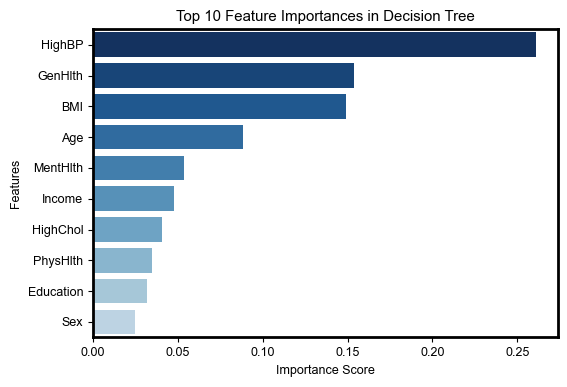

In [99]:
dt_feature_importances = dt_best.best_estimator_.feature_importances_
dt_indices = np.argsort(dt_feature_importances)[::-1]

N = 10
dt_top_features = X_train.columns[dt_indices[:N]]
dt_top_importances = dt_feature_importances[dt_indices[:N]]
dt_selected_features = DecisionTreeClassifier(**dt_best.best_params_)
dt_selected_features.fit(X_train[dt_top_features], y_train)

n_colors = len(dt_top_features)
colors = plt.cm.Blues(np.linspace(1, .3, n_colors))

dt_selected_feature_predictions = dt_selected_features.predict(X_test[dt_top_features])
print("Classification Report with Selected Features:\n")
print(classification_report(y_test, dt_selected_feature_predictions))

plt.figure(figsize=(6, 4))
sns.barplot(x=dt_top_importances, y=dt_top_features, palette=colors)
plt.title('Top 10 Feature Importances in Decision Tree')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.savefig('figures/dt_features.svg', format='svg')
plt.savefig('figures/dt_features.png', dpi = 300)
plt.show()

In [100]:
dt_top_features_str = '\n'.join(dt_top_features)
with open('features/dt_top_features.txt', 'w') as file:
    file.write(dt_top_features_str)


### Decision Tree With Bagging + Feature Importance

In [101]:
bagging_clf = BaggingClassifier(
    estimator=DecisionTreeClassifier(**dt_best.best_params_),
    n_estimators=100,
    random_state=42,
    oob_score=True
)

bagging_clf.fit(X_train, y_train)

print("OOB Score for Bagging:", bagging_clf.oob_score_)

OOB Score for Bagging: 0.7409751960115021


In [102]:
bagging_predictions = bagging_clf.predict(X_test)
print("\nDecision Tree with Bagging Classification Report:\n")
print(classification_report(y_test, bagging_predictions))


Decision Tree with Bagging Classification Report:

              precision    recall  f1-score   support

         0.0       0.77      0.71      0.74     10120
         1.0       0.74      0.80      0.77     10598

    accuracy                           0.75     20718
   macro avg       0.75      0.75      0.75     20718
weighted avg       0.75      0.75      0.75     20718



Bagging Classification Report with Selected Features:

              precision    recall  f1-score   support

         0.0       0.77      0.70      0.73     10120
         1.0       0.73      0.80      0.76     10598

    accuracy                           0.75     20718
   macro avg       0.75      0.75      0.75     20718
weighted avg       0.75      0.75      0.75     20718



C:\Users\matth\anaconda3\envs\ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\matth\anaconda3\envs\ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\matth\anaconda3\envs\ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


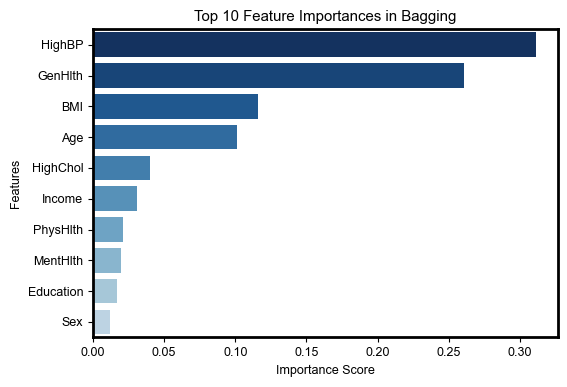

In [103]:
importances = np.mean([
    tree.feature_importances_ for tree in bagging_clf.estimators_
], axis=0)
indices_bagging = np.argsort(importances)[::-1]
top_features_bagging = X_train.columns[indices_bagging[:N]]
top_importances_bagging = importances[indices_bagging[:N]]

bagging_selected_features = BaggingClassifier(estimator=DecisionTreeClassifier(**dt_best.best_params_), n_estimators=100, random_state=42)
bagging_selected_features.fit(X_train[top_features_bagging], y_train)

n_colors = len(top_features_bagging)
colors = plt.cm.Blues(np.linspace(1, .3, n_colors))

bagging_feature_predictions = bagging_selected_features.predict(X_test[top_features_bagging])
print("Bagging Classification Report with Selected Features:\n")
print(classification_report(y_test, bagging_feature_predictions))


plt.figure(figsize=(6, 4))
sns.barplot(x=top_importances_bagging, y=top_features_bagging, palette = colors)
plt.title('Top 10 Feature Importances in Bagging')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.savefig('figures/bagging_features.svg', format='svg')
plt.savefig('figures/bagging_features.png', dpi = 300)

plt.show()

In [104]:
bagging_top_features_str = '\n'.join(top_features_bagging)
with open('features/bagging_top_features.txt', 'w') as file:
    file.write(bagging_top_features_str)

### Random Forest + Feature Importance

In [105]:
rf = RandomForestClassifier(**rf_best.best_params_)
rf.fit(X_train, y_train)
rf_predictions = rf.predict(X_test)
print("\nRandom Forest Classification Report:\n")
print(classification_report(y_test, rf_predictions))


Random Forest Classification Report:

              precision    recall  f1-score   support

         0.0       0.77      0.70      0.73     10120
         1.0       0.74      0.79      0.76     10598

    accuracy                           0.75     20718
   macro avg       0.75      0.75      0.75     20718
weighted avg       0.75      0.75      0.75     20718



Classification Report with Selected Features:

              precision    recall  f1-score   support

         0.0       0.75      0.69      0.72     10120
         1.0       0.73      0.78      0.76     10598

    accuracy                           0.74     20718
   macro avg       0.74      0.74      0.74     20718
weighted avg       0.74      0.74      0.74     20718



C:\Users\matth\anaconda3\envs\ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\matth\anaconda3\envs\ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\matth\anaconda3\envs\ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


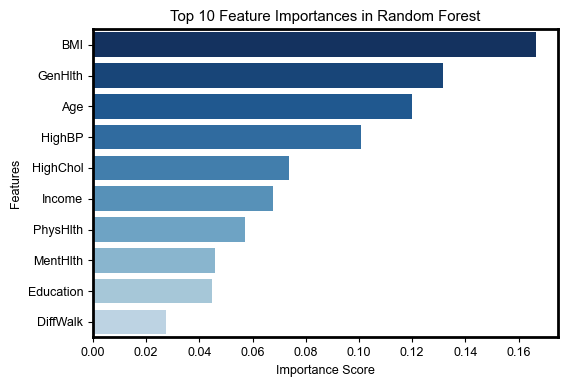

In [106]:
rf_feature_importances = rf_best.best_estimator_.feature_importances_
rf_indices = np.argsort(rf_feature_importances)[::-1]

rf_top_features = X_train.columns[rf_indices[:N]]
rf_top_importances = rf_feature_importances[rf_indices[:N]]
rf_selected_features = RandomForestClassifier(**rf_best.best_params_)
rf_selected_features.fit(X_train[rf_top_features], y_train)

n_colors = len(rf_top_features)
colors = plt.cm.Blues(np.linspace(1, .3, n_colors))

rf_selected_feature_predictions = rf_selected_features.predict(X_test[rf_top_features])
print("Classification Report with Selected Features:\n")
print(classification_report(y_test, rf_selected_feature_predictions))

plt.figure(figsize=(6, 4))
sns.barplot(x=rf_top_importances, y=rf_top_features, palette = colors)
plt.title('Top 10 Feature Importances in Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.savefig('figures/rf_features.svg', format='svg')
plt.savefig('figures/rf_features.png', dpi = 300)

plt.show()

In [107]:
rf_top_features_str = '\n'.join(rf_top_features)
with open('features/rf_top_features.txt', 'w') as file:
    file.write(rf_top_features_str)

### XGBoost + Feature Importances

In [108]:
xgb = XGBClassifier(eval_metric='logloss', device ="cpu", random_state=42, **xgb_best.best_params_)
xgb.fit(X_train, y_train)
xgb_predictions = xgb_best.predict(X_test)

print("\nXGBoost Classification Report:\n")
print(classification_report(y_test, xgb_predictions))


XGBoost Classification Report:

              precision    recall  f1-score   support

         0.0       0.74      0.72      0.73     10120
         1.0       0.74      0.76      0.75     10598

    accuracy                           0.74     20718
   macro avg       0.74      0.74      0.74     20718
weighted avg       0.74      0.74      0.74     20718



Classification Report with Selected Features:

              precision    recall  f1-score   support

         0.0       0.76      0.70      0.73     10120
         1.0       0.74      0.79      0.76     10598

    accuracy                           0.75     20718
   macro avg       0.75      0.75      0.75     20718
weighted avg       0.75      0.75      0.75     20718



C:\Users\matth\anaconda3\envs\ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\matth\anaconda3\envs\ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\matth\anaconda3\envs\ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


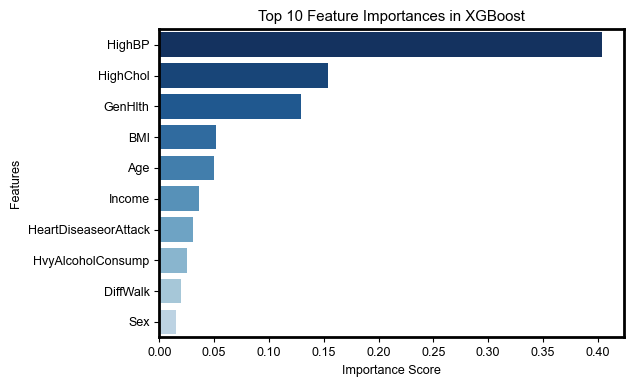

In [109]:
xgb_feature_importances = xgb_best.best_estimator_.feature_importances_
xgb_indices = np.argsort(xgb_feature_importances)[::-1]

xgb_top_features = X_train.columns[xgb_indices[:N]]
xgb_top_importances = xgb_feature_importances[xgb_indices[:N]]
xgb_selected_features = XGBClassifier(**xgb_best.best_params_)
xgb_selected_features.fit(X_train[xgb_top_features], y_train)

n_colors = len(xgb_top_features)
colors = plt.cm.Blues(np.linspace(1, .3, n_colors))

xgb_selected_feature_predictions = xgb_selected_features.predict(X_test[xgb_top_features])
print("Classification Report with Selected Features:\n")
print(classification_report(y_test, xgb_selected_feature_predictions))

plt.figure(figsize=(6, 4))
sns.barplot(x=xgb_top_importances, y=xgb_top_features, palette = colors)
plt.title('Top 10 Feature Importances in XGBoost')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.savefig('figures/xgb_features.svg', format='svg')
plt.savefig('figures/xgb_features.png', dpi=300)

plt.show()

In [110]:
xgb_top_features_str = '\n'.join(xgb_top_features)
with open('features/xgb_top_features.txt', 'w') as file:
    file.write(xgb_top_features_str)

### Dump Models

In [37]:
models_path = 'models/sklearn'


models = [lr_best, lda, knn_best, dt_best, dt_selected_features, bagging_clf,
          bagging_selected_features, rf_best, rf_selected_features, xgb_best, xgb_selected_features]

model_names = ['lr_best', 'lda', 'knn_best', 'dt_best', 'dt_selected_features', 'bagging_clf',
               'bagging_selected_features', 'rf_best', 'rf_selected_features', 'xgb_best', 'xgb_selected_features']

for model, name in zip(models, model_names):
    file_path = os.path.join(models_path, name + '.joblib')
    dump(model, file_path)
    print(f"Saved {name} to {file_path}")

Saved lr_best to models/sklearn\lr_best.joblib
Saved lda to models/sklearn\lda.joblib
Saved knn_best to models/sklearn\knn_best.joblib
Saved dt_best to models/sklearn\dt_best.joblib
Saved dt_selected_features to models/sklearn\dt_selected_features.joblib
Saved bagging_clf to models/sklearn\bagging_clf.joblib
Saved bagging_selected_features to models/sklearn\bagging_selected_features.joblib
Saved rf_best to models/sklearn\rf_best.joblib
Saved rf_selected_features to models/sklearn\rf_selected_features.joblib
Saved xgb_best to models/sklearn\xgb_best.joblib
Saved xgb_selected_features to models/sklearn\xgb_selected_features.joblib


## Neural Network

In [132]:
X_tensor = torch.FloatTensor(X.values)
y_tensor = torch.FloatTensor(y.values).unsqueeze(1)

dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.70 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset))


In [133]:
class FFNN(nn.Module):
    def __init__(self, input_dim):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.25)
        
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        
        x = torch.sigmoid(self.fc4(x))
        return x

class LitModel(pl.LightningModule):

    def __init__(self, input_dim, lr=1e-3):
        super(LitModel, self).__init__()
        self.model = FFNN(input_dim)
        self.lr = lr
        self.loss = nn.BCEWithLogitsLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss(y_hat, y)
        self.log('val_loss', loss)

    def configure_optimizers(self):
        return torch.optim.RMSprop(self.parameters(), lr=self.lr, alpha=0.99, eps=1e-08)

### Training

In [134]:
input_dim = X.shape[1]

FFNN  = LitModel(input_dim, lr = 0.046)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=True,
    mode='min',
    min_delta=0.00
)
trainer = pl.Trainer(logger=False, max_epochs=100, accelerator="gpu", enable_progress_bar=False, callbacks=[early_stopping])
trainer.fit(FFNN, train_loader, val_loader)

# Saving the model using PyTorch Lightning's built-in method
trainer.save_checkpoint("models/pytorch/ffnn.ckpt")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
C:\Users\matth\anaconda3\envs\ml\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:615: UserWarning: Checkpoint directory C:\Users\matth\OneDrive - University of Central Florida\Fall 2023\Big Data Analytics\STA4724\Project\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | 

In [135]:
best_model = FFNN

## Final Evaluation

In [136]:
model_names = ['lr_best', 'lda', 'knn_best', 'dt_best', 'dt_selected_features', 'bagging_clf',
               'bagging_selected_features', 'rf_best', 'rf_selected_features', 'xgb_best', 'xgb_selected_features']

models_path = 'models/sklearn/'
lr_best, lda, knn_best, dt_best, dt_selected_features, bagging_clf, \
bagging_selected_features, rf_best, rf_selected_features, xgb_best, xgb_selected_features = \
    (load(os.path.join(models_path, f'{name}.joblib')) for name in model_names)

In [137]:
def load_top_features(filename):
    with open(filename, 'r') as file:
        return file.read().splitlines()

In [138]:
top_features_bagging = load_top_features('features/bagging_top_features.txt')
top_features_dt = load_top_features('features/dt_top_features.txt')
top_features_rf = load_top_features('features/rf_top_features.txt')
top_features_xgb = load_top_features('features/xgb_top_features.txt')

In [139]:
#input_dim = X.shape[1]
#best_model = LitModel.load_from_checkpoint(input_dim = input_dim, checkpoint_path="models/pytorch/ffnn.ckpt")

In [140]:
def gain_in_first_decile(y_true, y_probs):
    y_true = np.array(y_true)
    
    sorted_indices = np.argsort(y_probs)[::-1]
    top_10_percent = int(0.1 * len(y_true))
    
    true_positives_in_decile = sum(y_true[sorted_indices][:top_10_percent])
    
    total_positives = sum(y_true)
    
    gain = true_positives_in_decile / total_positives
    return gain


In [141]:
all_probs_nn = []
all_true_labels_nn = []

with torch.no_grad():
    best_model.eval()
    best_model = best_model.cuda()
    
    for batch in val_loader:
        X_batch, y_batch = batch
        probs_batch = torch.sigmoid(best_model(X_batch.cuda())).cpu().numpy()
        all_probs_nn.extend(probs_batch)
        all_true_labels_nn.extend(y_batch.numpy())
        
best_accuracy = 0
best_threshold = 0
best_preds = []

for threshold in np.arange(0.1, 0.9, 0.05):
    preds = [1 if prob > threshold else 0 for prob in all_probs_nn]
    
    accuracy = accuracy_score(all_true_labels_nn, preds)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = threshold
        best_preds = preds

print(f"Best Accuracy: {best_accuracy} at Threshold: {best_threshold}")

print("\nClassification Report for Best Accuracy Threshold:\n")
print(classification_report(all_true_labels_nn, best_preds))


all_probs_nn = np.array(all_probs_nn).squeeze()
all_true_labels_nn = np.array(all_true_labels_nn).squeeze()

model_probs = {}
models = [lr_best, lda, knn_best, dt_best, dt_selected_features, bagging_clf,
          bagging_selected_features, rf_best, rf_selected_features, xgb_best, xgb_selected_features]

model_names = ['lr_best', 'lda', 'knn_best', 'dt_best', 'dt_selected_features', 'bagging_clf',
               'bagging_selected_features', 'rf_best', 'rf_selected_features', 'xgb_best', 'xgb_selected_features']

for name, model in zip(model_names, models):
    if name.endswith('_selected_features'):
        if name == 'dt_selected_features':
            top_features = top_features_dt
        elif name == 'bagging_selected_features':
            top_features = top_features_bagging
        elif name == 'rf_selected_features':
            top_features = top_features_rf
        elif name == 'xgb_selected_features':
            top_features = top_features_xgb
        
        probs = model.predict_proba(X_test[top_features])[:, 1]

    else:
        if name == 'knn_best':
            probs = model.predict_proba(X_test.values)[:, 1]
        else:
            probs = model.predict_proba(X_test)[:, 1]

    model_probs[name] = probs

probs_list = []

for name in model_probs:
    probs_list.append(model_probs[name])

probs_list.append(all_probs_nn)

Best Accuracy: 0.7470315667535476 at Threshold: 0.6000000000000002

Classification Report for Best Accuracy Threshold:

              precision    recall  f1-score   support

         0.0       0.77      0.69      0.73     10101
         1.0       0.73      0.80      0.76     10617

    accuracy                           0.75     20718
   macro avg       0.75      0.75      0.75     20718
weighted avg       0.75      0.75      0.75     20718



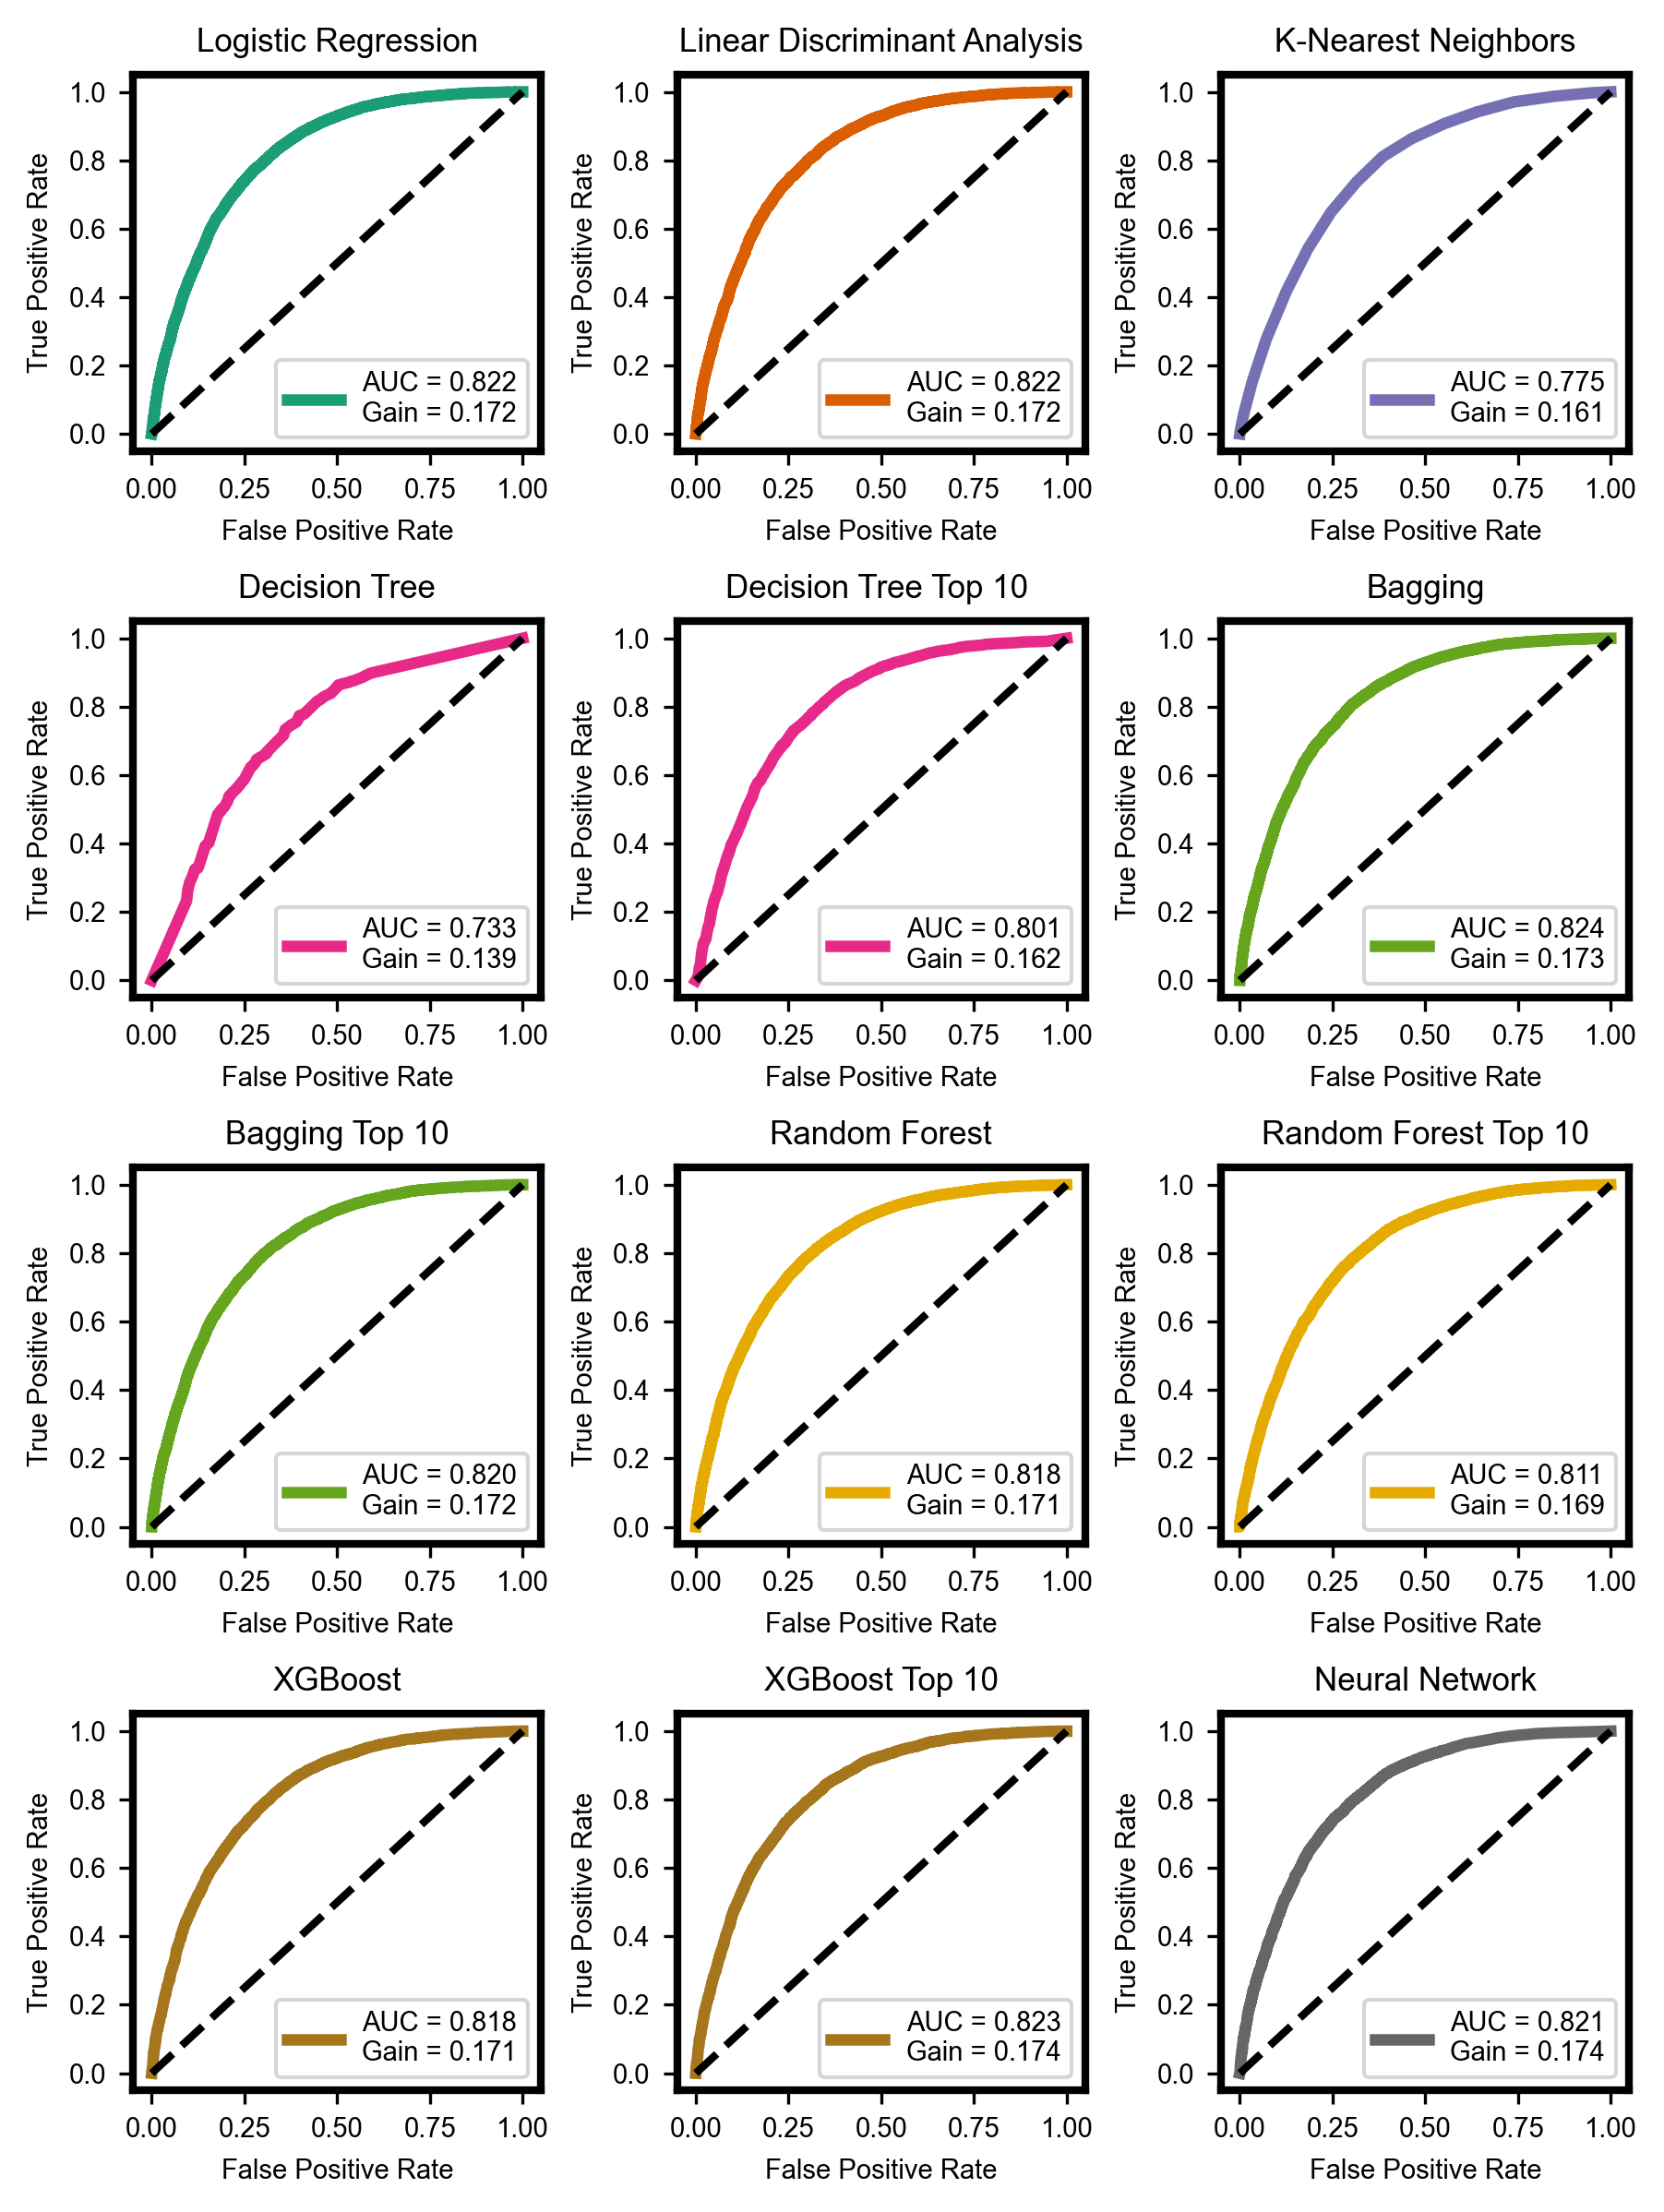

In [144]:
labels = ['Logistic Regression', 'Linear Discriminant Analysis', 'K-Nearest Neighbors', 'Decision Tree', 'Decision Tree Top 10 ', 'Bagging',
         'Bagging Top 10', 'Random Forest', 'Random Forest Top 10', 'XGBoost', 'XGBoost Top 10', 'Neural Network']

# Map each model type to a specific color
model_types = ['Logistic Regression', 'Linear Discriminant Analysis', 'K-Nearest Neighbors', 'Decision Tree', 'Bagging', 'Random Forest', 'XGBoost', 'Neural Network']
colors = plt.cm.Dark2(np.linspace(0, 1, len(model_types)))
color_map = dict(zip(model_types, colors))

fig, axes = plt.subplots(4, 3, figsize=(6, 8), dpi=300)
axes = axes.ravel()

for idx, (prob, label) in enumerate(zip(probs_list, labels)):
    # Determine the model type and assign the corresponding color
    # Remove 'Top 10' if it exists in the label
    model_type = ' '.join(label.split()[:-2]) if 'Top 10' in label else label
    color = color_map[model_type]

    if label == 'Neural Network':
        y_true = all_true_labels_nn
    else:
        y_true = y_test

    fpr, tpr, _ = roc_curve(y_true, prob)
    auc = roc_auc_score(y_true, prob)
    gain = gain_in_first_decile(y_true, prob)
    axes[idx].plot(fpr, tpr, label=f'AUC = {auc:.3f}\nGain = {gain:.3f}', color=color, linewidth=3)
    axes[idx].plot([0, 1], [0, 1], 'k--', lw=2)
    axes[idx].set_title(label)
    axes[idx].legend(loc='lower right')
    axes[idx].set_xlabel('False Positive Rate')
    axes[idx].set_ylabel('True Positive Rate')

plt.tight_layout()
plt.savefig('figures/auc_suite.svg', format='svg')
plt.show()